In [1]:
%load_ext autoreload
%autoreload 2

import argparse
from collections import OrderedDict
import datetime
import gc
#get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib
import matplotlib.pylab as plt
from numbers import Number
import numpy as np
import pandas as pd
pd.options.display.max_rows = 1500
pd.options.display.max_columns = 200
pd.options.display.width = 1000
pd.set_option('max_colwidth', 400)
import pdb
import pickle
import pprint as pp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from deepsnap.batch import Batch as deepsnap_Batch
import xarray as xr

import sys, os
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', '..'))
from le_pde.argparser import arg_parse
from le_pde.datasets.load_dataset import load_data
from le_pde.models import load_model
from le_pde.pytorch_net.util import groupby_add_keys, filter_df, get_unique_keys_df, Attr_Dict, Printer, get_num_params, get_machine_name, pload, pdump, to_np_array, get_pdict, reshape_weight_to_matrix, ddeepcopy as deepcopy, plot_vectors, record_data, filter_filename, Early_Stopping, str2bool, get_filename_short, print_banner, plot_matrices, get_num_params, init_args, filter_kwargs, to_string, COLOR_LIST
from le_pde.utils import update_legacy_default_hyperparam, EXP_PATH
from le_pde.utils import deepsnap_to_pyg, LpLoss, to_cpu, to_tuple_shape, parse_multi_step, loss_op, get_device

#device = torch.device("cuda:0")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
p = Printer()

c:\Users\scoc\Anaconda3\envs\le_pde\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Functions:

In [2]:
# Plotting:
def plot_learning_curve(data_record):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(data_record["epoch"], data_record["train_loss"], label="train")
    plt.plot(data_record["test_epoch"] if "test_epoch" in data_record else data_record["epoch"], data_record["val_loss"], label="val")
    plt.plot(data_record["test_epoch"] if "test_epoch" in data_record else data_record["epoch"], data_record["test_loss"], label="test")
    plt.title("Learning curve, linear scale")
    plt.legend()
    plt.subplot(1,2,2)
    plt.semilogy(data_record["epoch"], data_record["train_loss"], label="train")
    plt.semilogy(data_record["test_epoch"] if "test_epoch" in data_record else data_record["epoch"], data_record["val_loss"], label="val")
    plt.semilogy(data_record["test_epoch"] if "test_epoch" in data_record else data_record["epoch"], data_record["test_loss"], label="test")
    plt.title("Learning curve, log scale")
    plt.legend()
    plt.show()


def plot_colorbar(matrix, vmax=None, vmin=None, cmap="seismic", label=None):
    if vmax==None:
        vmax = matrix.max()
        vmin = matrix.min()
    im = plt.imshow(matrix,vmax=vmax,vmin=vmin,cmap=cmap)
    plt.title(label)
    im_ratio = matrix.shape[0]/matrix.shape[1]
    plt.colorbar(im,fraction=0.046*im_ratio,pad=0.04)


def visualize(pred, gt, animate=False):
    if torch.is_tensor(gt):
        gt = to_np_array(gt)
        pred = to_np_array(pred)
    mse_over_t = ((gt-pred)**2).mean(axis=0).mean(axis=-1)
     
    if not animate:
        vmax = gt.max()
        vmin = gt.min()
        plt.figure(figsize=[15,5])
        plt.subplot(1,4,1)
        plot_colorbar(gt[:,:,0].T,label="gt")
        plt.subplot(1,4,2)
        plot_colorbar(pred[:,:,0].T,label="pred")
        plt.subplot(1,4,3)
        plot_colorbar((pred-gt)[:,:,0].T,vmax=np.abs(pred-gt).max(),vmin=(-1*np.abs(pred-gt).max()),label="diff")
        plt.subplot(1,4,4)
        plt.plot(mse_over_t);plt.title("mse over t");plt.yscale('log');
        plt.tight_layout()
        plt.show()

def visualize_paper(pred, gt, is_save=False):
    idx = 6
    nx = pred.shape[0]

    fontsize = 14
    idx_list = np.arange(0, 200, 15)
    color_list = np.linspace(0.01, 0.9, len(idx_list))
    x_axis = np.linspace(0,16,nx)
    cmap = matplotlib.cm.get_cmap('jet')

    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    for i, idx in enumerate(idx_list):
        pred_i = to_np_array(pred[...,idx,:].squeeze())
        rgb = cmap(color_list[i])[:3]
        plt.plot(x_axis, pred_i, color=rgb, label=f"t={np.round(i*0.3, 1)}s")
    plt.ylabel("u(t,x)", fontsize=fontsize)
    plt.xlabel("x", fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    # plt.legend(fontsize=10, bbox_to_anchor=[1,1])
    plt.xticks([0,8,16], [0,8,16])
    plt.ylim([-2.5,2.5])
    plt.title("Prediction")
    if is_save:
        plt.savefig(f"1D_E2-{nx}.pdf", bbox_inches='tight')

    plt.subplot(1,2,2)
    for i, idx in enumerate(idx_list):
        y_i = to_np_array(gt[...,idx,:])
        rgb = cmap(color_list[i])[:3]
        plt.plot(x_axis, y_i, color=rgb, label=f"t={np.round(i*0.3, 1)}s")
    plt.ylabel("u(t,x)", fontsize=fontsize)
    plt.xlabel("x", fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    plt.legend(fontsize=10, bbox_to_anchor=[1,1])
    plt.xticks([0,8,16], [0,8,16])
    plt.ylim([-2.5,2.5])
    plt.title("Ground-truth")
    if is_save:
        plt.savefig(f"1D_gt-{nx}.pdf", bbox_inches='tight')
    plt.show()

In [3]:
# Analysis:
def get_results_1d(
    all_hash,
    mode="best",
    exclude_idx=(None,),
    n_rollout_steps=-1,
    dirname=None,
    suffix="",
):
    """
    Perform analysis on the 1D Burgers' benchmark.

    Args:
        all_hash: a list of hashes which indicates the experiments to load for analysis
        mode: choose from "best" (load the best model with lowest validation loss) or an integer, 
            e.g. -1 (last saved model), -2 (second last saved model)
        dirname: if not None, will use the dirnaem provided. E.g. tailin-1d_2022-7-27
        suffix: suffix for saving the analysis result.
    """

    isplot = True
    df_dict_list = []
    dirname_start = dirname
    for hash_str in all_hash:
        df_dict = {}
        df_dict["hash"] = hash_str
        # Load model:
        is_found = False
        for dirname_core in [
             dirname_start,
            ]:
            filename = filter_filename(EXP_PATH + dirname_core, include=hash_str)
            if len(filename) == 1:
                is_found = True
                break
        if not is_found:
            print(f"hash {hash_str} does not exist in {dirname}! Please pass in the correct dirname.")
            continue
        dirname = EXP_PATH + dirname_core
        if not dirname.endswith("/"):
            dirname += "/"

        try:
            data_record = pload(dirname + filename[0])
        except Exception as e:
            # p.print(f"Hash {hash_str}, best model at epoch {data_record['best_epoch']}:", banner_size=100)
            print(f"error {e} in hash_str {hash_str}")
            continue
        p.print(f"Hash {hash_str}, best model at epoch {data_record['best_epoch']}:", banner_size=160)
        if isplot:
            plot_learning_curve(data_record)
        args = init_args(update_legacy_default_hyperparam(data_record["args"]))
        args.filename = filename
        if mode == "best":
            model = load_model(data_record["best_model_dict"], device=device)
            print("Load the model with best validation loss.")
        else:
            assert isinstance(mode, int)
            print(f'Load the model at epoch {data_record["epoch"][mode]}')
            model = load_model(data_record["model_dict"][mode], device=device)
        model.eval()
        # pp.pprint(args.__dict__)
        kwargs = {}
        if data_record["best_model_dict"]["type"].startswith("GNNPolicy"):
            kwargs["is_deepsnap"] = True

        # Load test dataset:
        args_test = deepcopy(args)
        multi_step = (250 - 50) // args_test.temporal_bundle_steps
        print("multistep -->", multi_step)
        args_test.multi_step = f"1*{multi_step}"
        args_test.is_test_only = True
        n_test_traj = 128
        (dataset_train_val, dataset_test), (train_loader, val_loader, test_loader) = load_data(args_test)
        nx = int(args.dataset.split("-")[2])
        time_stamps_effective = len(dataset_test) // n_test_traj
        print("len of test dataset -->",len(dataset_test))
        print("time_stamps_effective -->", time_stamps_effective)
        for exclude_idx_ele in exclude_idx:
            loss_list = []
            pred_list = []
            y_list = []
            for i in range(n_test_traj):
                idx = i * time_stamps_effective + args_test.temporal_bundle_steps
                data = deepcopy(dataset_test[idx])
                data = data.to(device)
                preds, info = model(
                    data,
                    pred_steps=np.arange(1,n_rollout_steps+1) if n_rollout_steps != -1 else np.arange(1, max(parse_multi_step(args_test.multi_step).keys())+1),
                    latent_pred_steps=None,
                    is_recons=False,
                    use_grads=False,
                    use_pos=args.use_pos,
                    is_y_diff=False,
                    is_rollout=False,
                    **kwargs
                )
                y = data.node_label["n0"]
                if n_rollout_steps != -1:
                    y = y[:,:25*n_rollout_steps]
                pred = preds["n0"].reshape(y.shape)
                pred_list.append(pred.detach())
                y_list.append(y.detach())
                loss_ele = nn.MSELoss(reduction="sum")(pred, y) / nx
                loss_list.append(loss_ele.item())

            loss_mean = np.mean(loss_list)
            pred_list = torch.stack(pred_list).squeeze(-1)
            y_list = torch.stack(y_list).squeeze(-1)
            df_dict[f"loss_cumu_{exclude_idx_ele}"] = loss_mean 
            print("\nTest for {} for exclude_idx={} is: {:.9f} at epoch {}, for {}/{} epochs".format(hash_str, exclude_idx_ele, loss_mean, data_record['best_epoch'], len(data_record["train_loss"]), args.epochs))

            mse_full = nn.MSELoss(reduction="none")(pred_list, y_list)
            mse_time = to_np_array(mse_full.mean((0,1)))
            p.print("Learning curve:", is_datetime=False, banner_size=100)
            plt.figure(figsize=(12,5))
            plt.subplot(1,2,1)
            plt.plot(mse_time)
            plt.xlabel("rollout step")
            plt.ylabel("MSE")
            plt.title("MSE vs. rollout step (linear scale)")
            plt.subplot(1,2,2)
            plt.semilogy(mse_time)
            plt.xlabel("rollout step")
            plt.ylabel("MSE")
            plt.title("MSE vs. rollout step (log scale)")
            plt.show()
            plt.figure(figsize=(6,5))
            plt.plot(mse_time.cumsum())
            plt.title("cumulative MSE vs. rollout step")
            plt.xlabel("rollout step")
            plt.ylabel("cumulative MSE")
            plt.show()

            # Visualization:
            for idx in range(6,8):
                p.print(f"Example {idx*12}:", banner_size=100, is_datetime=False)
                data = deepcopy(dataset_test[idx*12]).to(device)
                preds, info = model(
                    data,
                    pred_steps=np.arange(1,max(parse_multi_step(args_test.multi_step).keys())+1),
                    latent_pred_steps=None,
                    is_recons=False,
                    use_grads=False,
                    use_pos=args.use_pos,
                    is_y_diff=False,
                    is_rollout=False,
                    **kwargs
                )
                y = data.node_label["n0"]
                pred = preds["n0"].reshape(y.shape)
                visualize(pred, y)
                visualize_paper(pred, y)

            p.print(f"Individual prediction at rollout step {y.shape[1]}:", banner_size=100, is_datetime=False)
            time_step = -1
            for idx in range(0, 20, 5):
                plt.figure(figsize=(6,4))
                plt.plot(to_np_array(pred_list[idx,:,time_step]), label="pred")
                plt.plot(to_np_array(y_list[idx,:,time_step]), "--", label="y")
                plt.legend()
                plt.show()
        df_dict["best_epoch"] = data_record['best_epoch']
        df_dict["epoch"] = len(data_record["train_loss"])
        df_dict.update(args.__dict__)
        df_dict_list.append(df_dict)
    df = pd.DataFrame(df_dict_list)
    pdump(df, f"df_1d{suffix}.p")
    return df

## 1. Analysis:

[2023-05-12 11:24:23] Hash UOL-LAP-594436, best model at epoch 5:


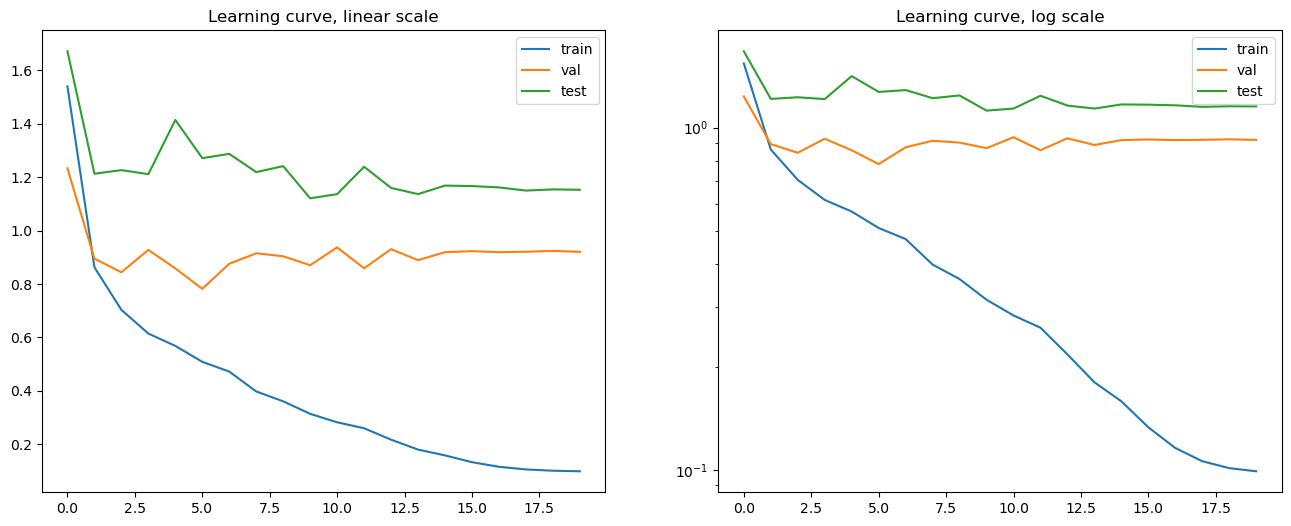

Load the model with best validation loss.
multistep --> 8
[2023-05-12 11:24:24] data/deepsnap\mppde1d-E2-50_test_in_25_out_200.p does not exist. Generating...
ckecingggg
is_test_only True
Load dataset data/mppde1d_data/CE_test_E2.h5
[2023-05-12 11:24:24] :
[2023-05-12 11:24:24] 200
[2023-05-12 11:24:24] saved generated deepsnap dataset to data/deepsnap\mppde1d-E2-50_test_in_25_out_200.p
len of test dataset --> 200
time_stamps_effective --> 1

Test for UOL-LAP-594436 for exclude_idx=None is: 38.349324860 at epoch 5, for 20/20 epochs
Learning curve:


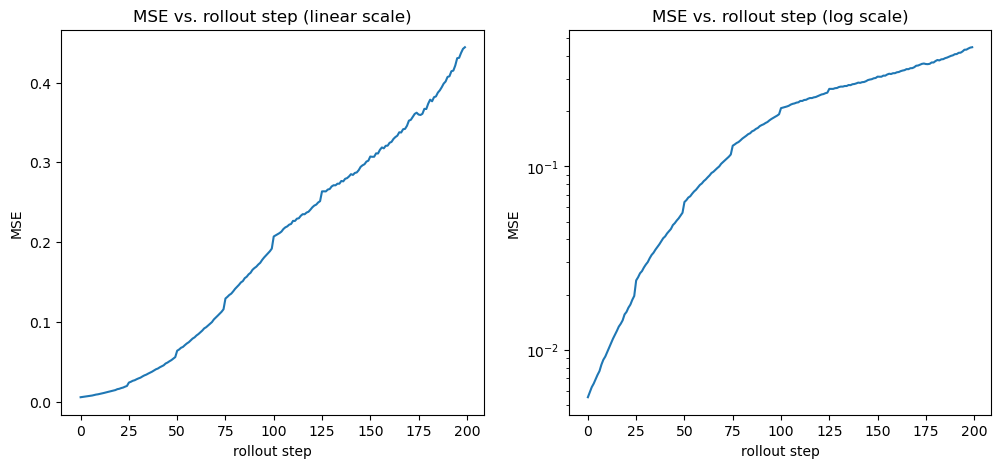

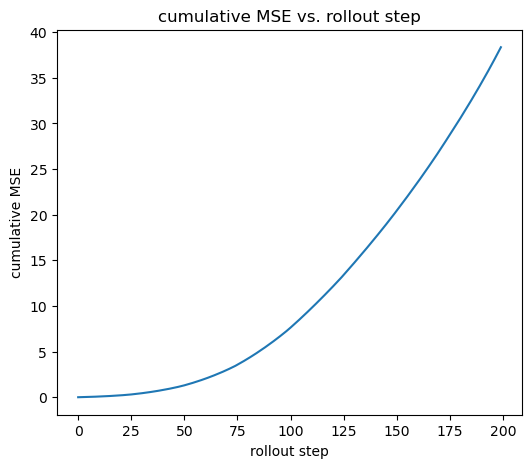

Example 72:


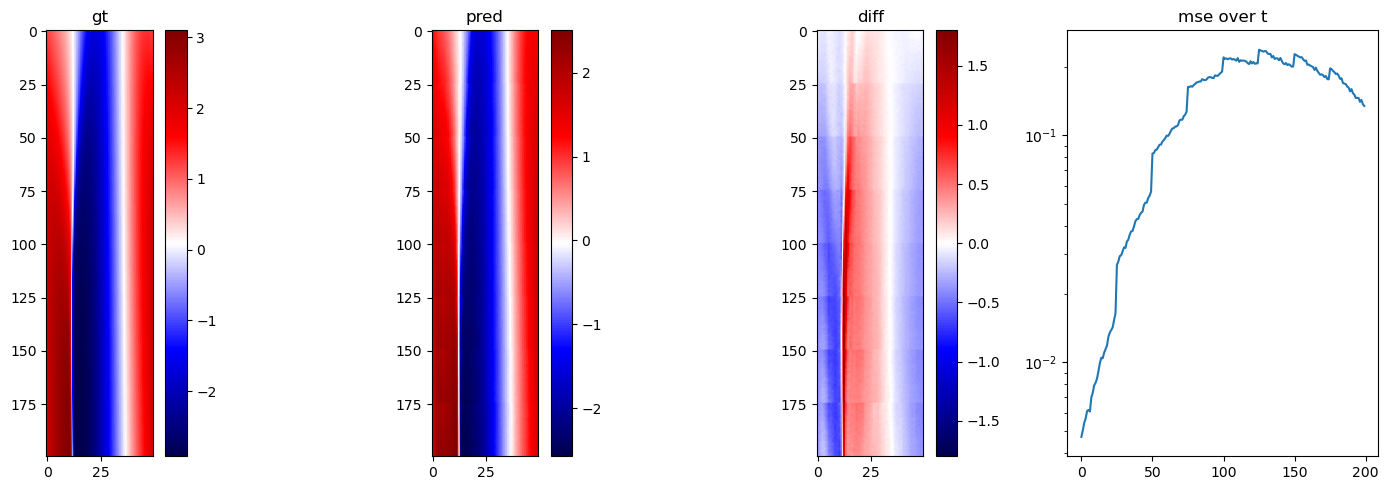

C:\Users\scoc\AppData\Local\Temp\ipykernel_12264\1084204629.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('jet')


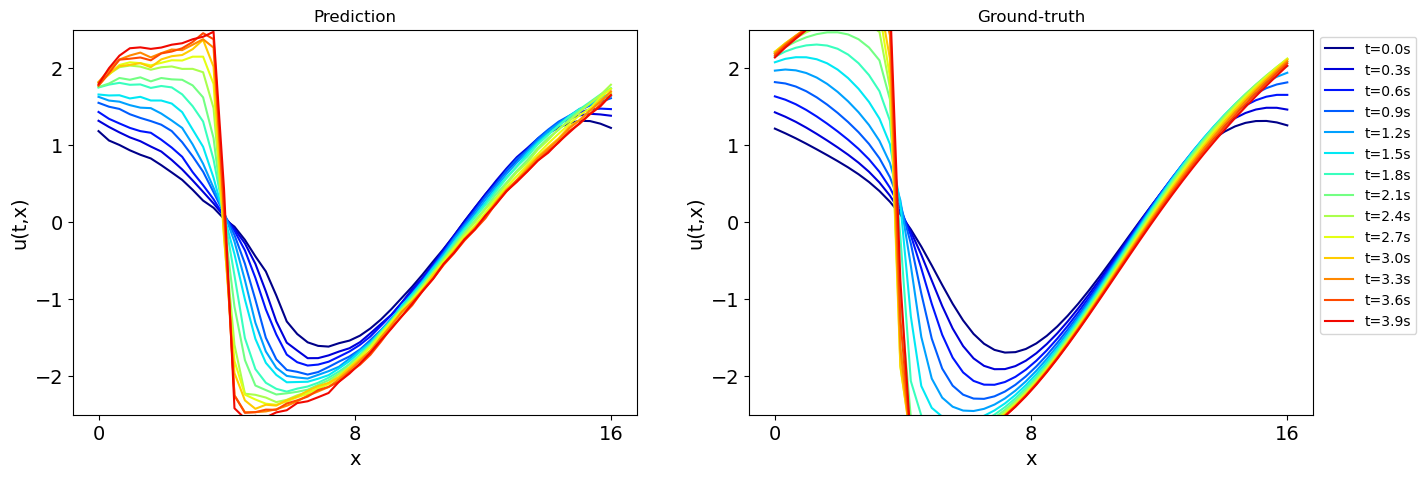

Example 84:


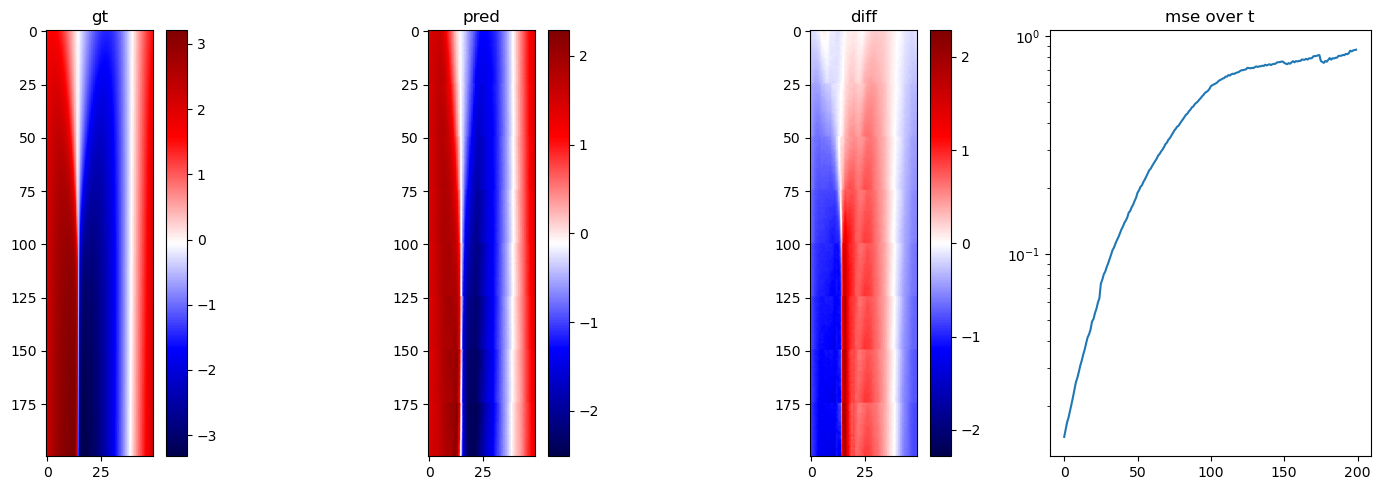

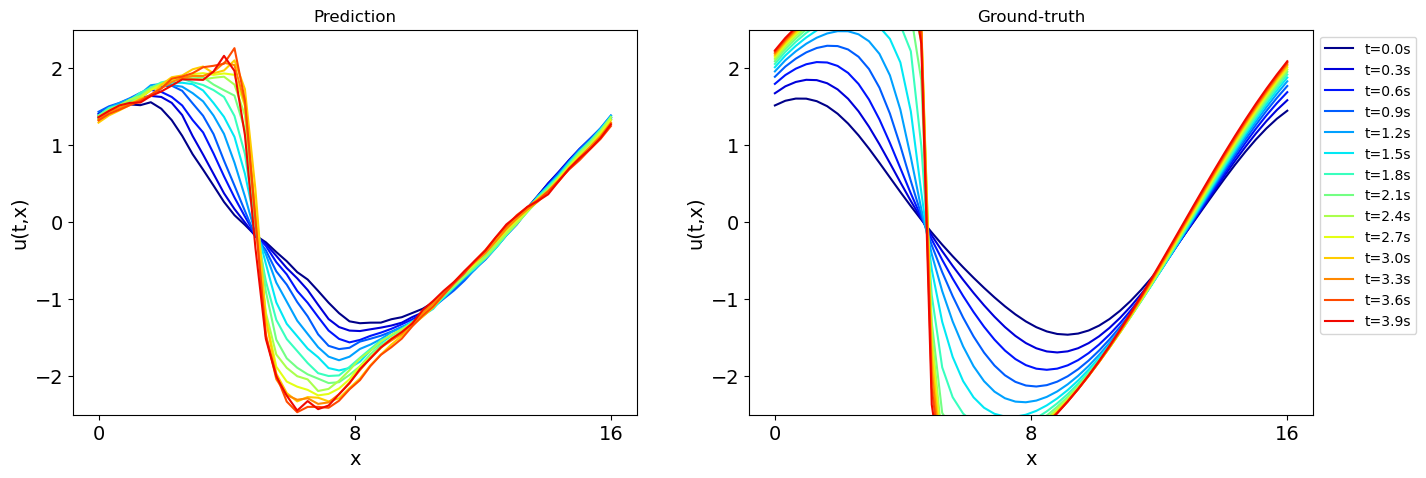

Individual prediction at rollout step 200:


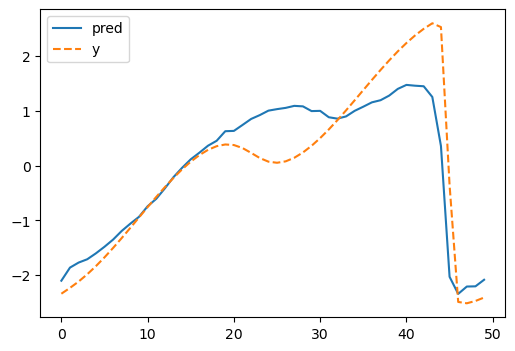

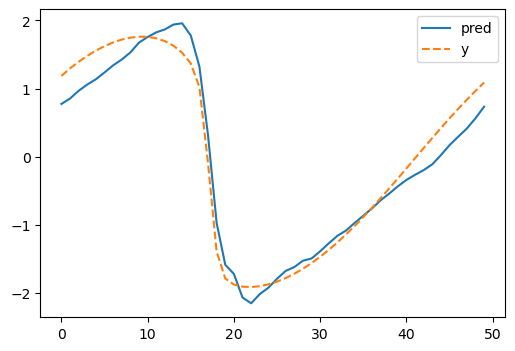

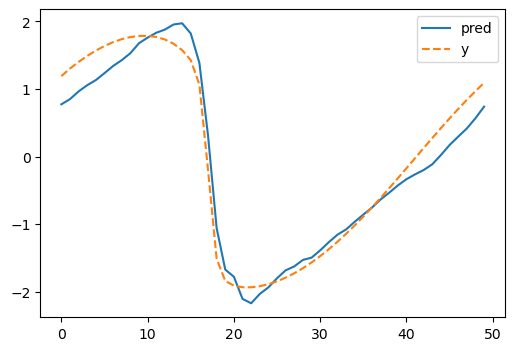

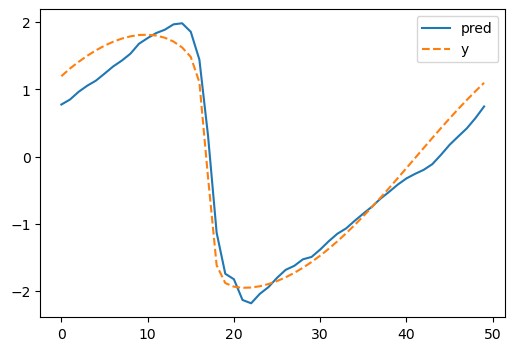

,hash,loss_cumu_None,best_epoch,epoch,exp_id,date_time,decoder_act_name,is_prioritized_dropout,save_interval,test_interval,save_iterations,verbose,is_test_only,is_tensorboard,wandb,wandb_project_name,wandb_step,wandb_step_plot,is_timing,is_unittest,seed,id,load_dirname,load_filename,load_exp_renew,dataset,dataset_split_type,data_noise_amp,train_fraction,time_interval,n_train,data_dropout,exclude_bdd,sector_size,sector_stride,is_y_variable_length,algo,latent_size,act_name,decoder_last_act_name,reg_type,reg_coef,is_reg_anneal,no_latent_evo,encoder_type,encoder_n_linear_layers,n_conv_blocks,n_latent_levs,n_conv_layers_latent,evo_conv_type,evo_pos_dims,evo_inte_dims,is_latent_flatten,encoder_mode,recons_coef,consistency_coef,contrastive_rel_coef,hinge,latent_noise_amp,density_coef,is_pos_transform,normalization_type,gnn_mlp_n_neurons,gnn_mlp_n_layers,synch,agg_type,channel_mode,kernel_size,stride,padding,padding_mode,output_padding_str,evo_groups,evolution_type,forward_type,decoder_type,layer_type,n_layers,dropout,unet_fmaps,is_pretrain_autoencode,vae_mode,vae_beta,epochs_pretrain,dp_mode,zero_weight,input_steps,temporal_bundle_steps,is_multistep_detach,input_steps_lazy,multi_step,multi_step_start_epoch,latent_multi_step,use_grads,use_pos,is_y_diff,epsilon_latent_loss,loss_type,loss_type_consistency,latent_loss_normalize_mode,batch_size,n_workers,val_batch_size,epochs,early_stopping_patience,opt,weight_decay,is_clip_grad,lr,lr_min_cos,lr_scheduler_type,lr_scheduler_factor,lr_scheduler_T0,lr_scheduler_T_mult,gpuid,static_latent_size,static_encoder_type,max_grad_norm,rl_coefs,rl_horizon,reward_mode,reward_beta,reward_loss_coef,reward_src,rl_gamma,rl_lambda,rl_rho,rl_eta,rl_critic_update_iterations,rl_data_dropout,rl_is_finetune_evolution,rl_is_alt_remeshing,top_k_action,opt_evl_horizon,evl_stop_gradient,actor_lr,actor_batch_norm,skip_coarse,skip_split,skip_flip,value_latent_size,value_num_pool,value_act_name,value_act_name_final,value_layer_norm,value_batch_norm,value_num_steps,value_pooling_type,value_lr,value_loss_type,value_loss_coef,test_value_model,value_target_mode,use_reward_vanilla,reward_condition,is_alternating_train,is_single_action,value_steps,actor_steps,test_data_interp,actor_critic_step,evolution_steps,offset_coarse,offset_split,rl_finetune_evalution_mode,max_action,kaction_pooling_type,connect_bdd,stop_all_gradient,is_eval_sample,debug,is_1d_periodic,is_normalize_pos,fine_tune_gt_input,soft_update,share_processor,policy_input_feature,load_hash,test_reward_random_sample,processor_aggr,fix_alt_evolution_model,disc_coef,disc_mode,disc_lr,disc_reg_type,disc_iters,disc_loss_type,disc_t,is_mesh,device,machine_name,is_vae,reinit_mode,filename
0,UOL-LAP-594436,38.349325,5,20,le-pde-1d,12-05-2023,None,False,5,1,1000,1,False,False,False,test,20,100,0,True,0,0,None,None,False,mppde1d-E2-50,standard,0.0,0.888889,1,-1,None,False,-1,-1,False,contrast,128,elu,linear,None,0,True,False,cnn-s,0,4,1,3,cnn,-1,-1,True,dense,1.0,1.0,0.0,0.0,0.00001,0.001,True,gn,64,2,False,mean,exp-32,4,2,1,zeros,1-0-1-0,1,mlp-3-elu-2,Euler,cnn-tr,graphsage,3,0.0,64,False,None,1,0,None,1,1,25,False,False,1*2*3*4,0,1*2*3*4,False,False,False,0,rmse,mse,targetindi,16,0,16,20,-1,adam,0.0,False,0.001,0,cos,0.1,2,1,False,3,param-0,-1,None,4,lossdiff+statediff,0.5,5,env,0.99,0.95,1.0,0.0001,100,None,False,False,1,-1,False,0.0005,False,False,False,False,32,1,elu,linear,False,False,3,global_mean_pool,0.0001,mse,0.5,False,value-lambda,False,False,False,False,None,None,False,None,None,0.0,0.0,None,5,global_mean_pool,False,True,True,False,False,True,False,False,True,velocity,None,False,max,False,0,Siamese-2,0.001,snn,5,hinge,None,False,cpu,UOL-LAP-594436,False,None,[mppde1d-E2-50_train_-1_algo_contrast_enc_cnn-s_evo_cnn_act_elu_hid_128_lo_rms_UOL-LAP-594436.p]


In [5]:
# all_hash is a list of hashes, each of which corresponds to one experiment.
# For example, if one experiment is saved under ./results/tailin-1d_2022-5-14/mppde1d-E2-50_train_-1_algo_contrast_ebm_False_ebmt_cd_enc_cnn-s_evo_cnn_act_elu_hid_128_lo_rmse_recef_1.0_conef_1.0_nconv_4_nlat_1_clat_3_lf_True_reg_None_id_0_Hash_Un6ae7ja_turing2.p
# Then, the "Un6ae7ja_turing2" (located at the end of the filename) is the {hash}_{machine-name} of this file.
# The "tailin-1d_2022-5-14" is the "{--exp_id}_{--date_time}" of the training command.
# all_hash can contain multiple hashes, and analyze them sequentially.
all_hash = [
    "UOL-LAP-594436",
]
get_results_1d(all_hash, dirname="le-pde-1d_12-05-2023")

## 2. Plotting:

[2023-05-12 11:56:08] Hash UOL-LAP-594436, best model at epoch 5:


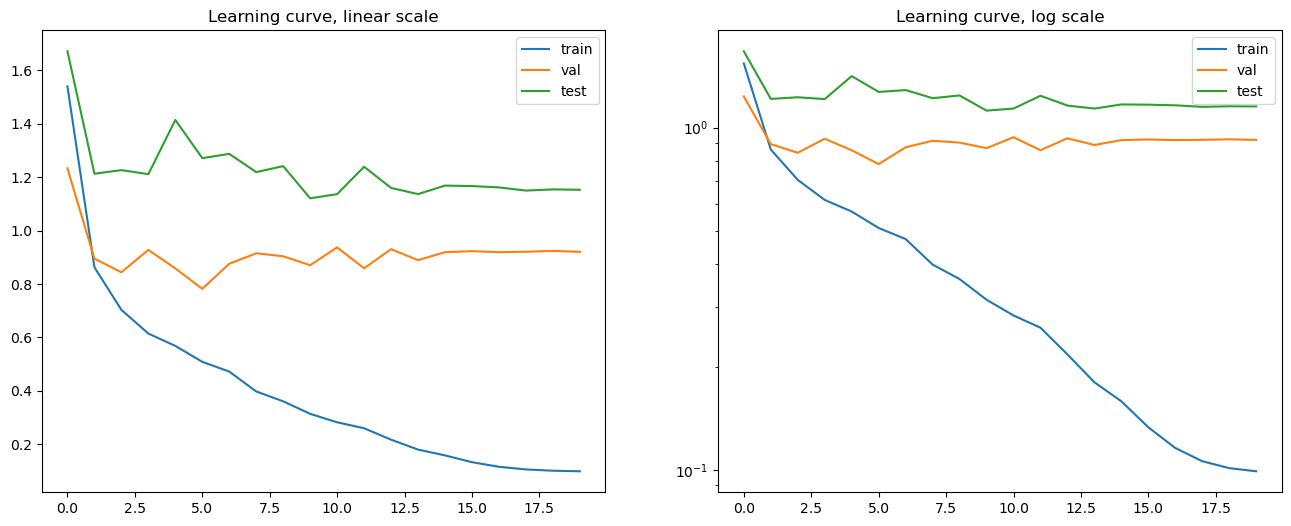

[2023-05-12 11:56:09] data/deepsnap\mppde1d-E2-50_test_in_25_out_225.p does not exist. Generating...
ckecingggg
is_test_only True
Load dataset data/mppde1d_data/CE_test_E2.h5
[2023-05-12 11:56:09] :
[2023-05-12 11:56:09] 128
[2023-05-12 11:56:09] saved generated deepsnap dataset to data/deepsnap\mppde1d-E2-50_test_in_25_out_225.p


In [10]:
hash_str = "UOL-LAP-594436" # E2-50
# hash_str = "nIa6UCdr_turing2" # E2-40
#hash_str = "tdu+jfKw"  # E2-100
dirname = EXP_PATH + "le-pde-1d_12-05-2023/"
all_dict = {}
isplot = True
# Load model:
filename = filter_filename(dirname, include=hash_str)
if len(filename) == 0:
    print(f"hash {hash_str} does not exist!")
    raise

try:
    data_record = pload(dirname + filename[0])
except Exception as e:
    # p.print(f"Hash {hash_str}, best model at epoch {data_record['best_epoch']}:", banner_size=100)
    print(f"error {e} in hash_str {hash_str}")
    raise
p.print(f"Hash {hash_str}, best model at epoch {data_record['best_epoch']}:", banner_size=100)
if isplot:
    plot_learning_curve(data_record)
args = init_args(update_legacy_default_hyperparam(data_record["args"]))
args.filename = filename
args.is_test_only = True
model = load_model(data_record["best_model_dict"], device=device)
# model = load_model(data_record["model_dict"][-1], device=device)
model.eval()


# Load test dataset:
args_test = deepcopy(args)
multi_step = (250 - 50) // args_test.temporal_bundle_steps
args_test.multi_step = f"1^{multi_step}"
(dataset_train_val, dataset_test), (train_loader, val_loader, test_loader) = load_data(args_test)


C:\Users\scoc\AppData\Local\Temp\ipykernel_12264\3764301006.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('jet')


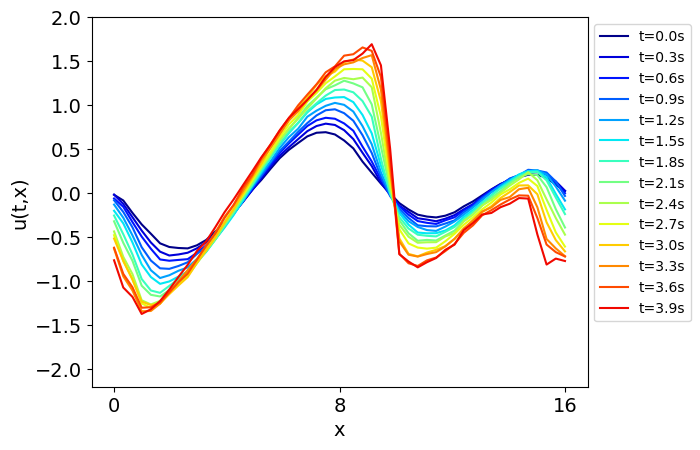

gt:


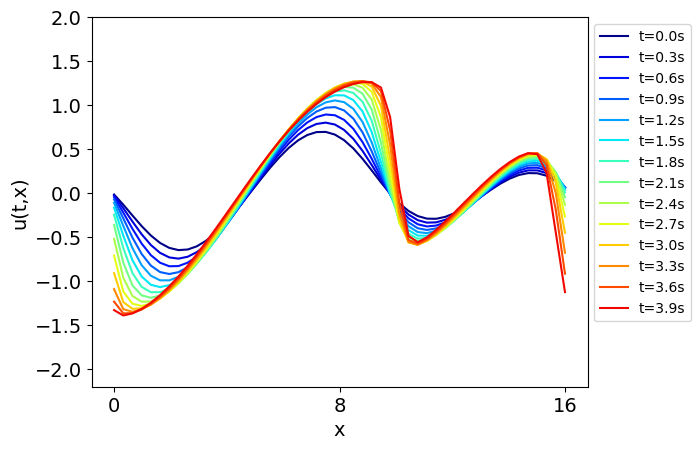

In [26]:
idx = 6
nx = 100
data = dataset_test[idx*10]
data.to(device)
preds, info = model(
    data,
    pred_steps=np.arange(1,max(parse_multi_step(args_test.multi_step).keys())+1),
    latent_pred_steps=None,
    is_recons=False,
    use_grads=False,
    is_y_diff=False,
    is_rollout=False,
)

fontsize = 14
idx_list = np.arange(0, 200, 15)
color_list = np.linspace(0.01, 0.9, len(idx_list))
x_axis = np.linspace(0,16,50)
cmap = matplotlib.cm.get_cmap('jet')
for i, idx in enumerate(idx_list):
    pred = to_np_array(preds["n0"][...,idx,:].squeeze())
    # y = to_np_array(data.node_label["n0"][...,idx,:])
    rgb = cmap(color_list[i])[:3]
    plt.plot(x_axis, pred, color=rgb, label=f"t={np.round(i*0.3, 1)}s")
plt.ylabel("u(t,x)", fontsize=fontsize)
plt.xlabel("x", fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.legend(fontsize=10, bbox_to_anchor=[1,1])
plt.xticks([0,8,16], [0,8,16])
plt.ylim([-2.2,2.])
plt.savefig(f"1D_E2-{nx}.pdf", bbox_inches='tight')
plt.show()

print("gt:")
for i, idx in enumerate(idx_list):
    pred = to_np_array(preds["n0"][...,idx,:].squeeze())
    y = to_np_array(data.node_label["n0"][...,idx,:])
    rgb = cmap(color_list[i])[:3]
    plt.plot(x_axis, y, color=rgb, label=f"t={np.round(i*0.3, 1)}s")
plt.ylabel("u(t,x)", fontsize=fontsize)
plt.xlabel("x", fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.legend(fontsize=10, bbox_to_anchor=[1,1])
plt.xticks([0,8,16], [0,8,16])
plt.ylim([-2.2,2.])
plt.savefig(f"1D_gt-{nx}.pdf", bbox_inches='tight')
plt.show()

## 3. Timing:

In [15]:
def get_timing_1d(all_hash, suffix=""):
    isplot = True

    dirname = EXP_PATH + "tailin-1d_2022-5-14/"
    all_dict = {}
    hash_str = all_hash[0]

    # Load model:
    filename = filter_filename(dirname, include=hash_str)
    if len(filename) == 0:
        dirname = EXP_PATH + "tailin-1d_2022-7-27/"
        filename = filter_filename(dirname, hash_str)
        if len(filename) == 0:
            print(f"hash {hash_str} does not exist!")
            raise

    try:
        data_record = pload(dirname + filename[0])
    except Exception as e:
        # p.print(f"Hash {hash_str}, best model at epoch {data_record['best_epoch']}:", banner_size=100)
        print(f"error {e} in hash_str {hash_str}")
        raise
    p.print(f"Hash {hash_str}, best model at epoch {data_record['best_epoch']}:", banner_size=100)
    if isplot:
        plot_learning_curve(data_record)
    args = init_args(update_legacy_default_hyperparam(data_record["args"]))
    args.filename = filename
    args.is_test_only = True
    model = load_model(data_record["best_model_dict"], device=device)
    # model = load_model(data_record["model_dict"][-1], device=device)
    model.eval()

    # Load test dataset:
    args_test = deepcopy(args)
    multi_step = (250 - 50) // args_test.temporal_bundle_steps
    args_test.multi_step = f"1^{multi_step}"

    args_test = deepcopy(args)
    args_test.multi_step = "1^8"
    (dataset_train_val, dataset_test), (train_loader, val_loader, test_loader) = load_data(args_test)
    idx_list = [i * 26 + 25 for i in range(128)]
    dataset_test_selected = dataset_test[idx_list]
    test_loader = DataLoader(dataset_test_selected, num_workers=0, collate_fn=deepsnap_Batch.collate(),
                             batch_size=len(dataset_test_selected), shuffle=False, drop_last=False)
    for data in test_loader:
        break
    data.to(device)

    for hash_str in all_hash:
        all_list_dict = {}
    for hash_str in all_hash:
        filename = filter_filename(dirname, hash_str)
        assert len(filename) == 1
        data_record = pload(dirname + filename[0])
        model = load_model(data_record["best_model_dict"], device=device)
        model.eval() 

        t_list = []
        for i in range(100):
            t_start = time.time()
            preds, info = model(
                data,
                pred_steps=np.arange(1,max(parse_multi_step(args_test.multi_step).keys())+1),
                latent_pred_steps=None,
                is_recons=False,
                use_grads=False,
                is_y_diff=False,
                is_rollout=False,
            )
            t_end = time.time()
            t_list.append(t_end - t_start)
            del preds
            gc.collect()
        full_time = np.mean(t_list)
        n_params = get_num_params(model)

        if model.__class__.__name__ == "Contrastive":
            t_list_evo = []
            for i in range(100):
                t_start = time.time()
                preds, info = model(
                    data,
                    pred_steps=[],
                    latent_pred_steps=np.arange(1,max(parse_multi_step(args_test.multi_step).keys())+1),
                    is_recons=False,
                    use_grads=False,
                    is_y_diff=False,
                    is_rollout=False,
                )
                t_end = time.time()
                t_list_evo.append(t_end - t_start)
                del preds
                gc.collect()
            evo_time = np.mean(t_list_evo)
            n_params_evo = get_num_params(model.evolution_op)
            print("hash {}, full time: {:.6f} +- {:.6f}  evo time: {:.6f} +- {:.6f}. #params: {}  #params_evo: {}.".format(
                hash_str, full_time, np.std(t_list),
                evo_time, np.std(t_list_evo),
                n_params, n_params_evo,
            ))
            all_list_dict[hash_str] = {
                "evo": t_list_evo,
                "full": t_list,
                "n_params": n_params,
                "n_params_evo": n_params_evo,
            }
        else:
            print("hash {}, full time: {:.6f} +- {:.6f}. #params: {}".format(
                hash_str, full_time, np.std(t_list), n_params))
            all_list_dict[hash_str] = {
                "full": t_list,
                "n_params": n_params,
            }
    pdump(all_list_dict, f"all_dict_1d_timing{suffix}.p")

[2022-08-01 13:22:55] Hash ldDNKnog_turing2, best model at epoch 49:


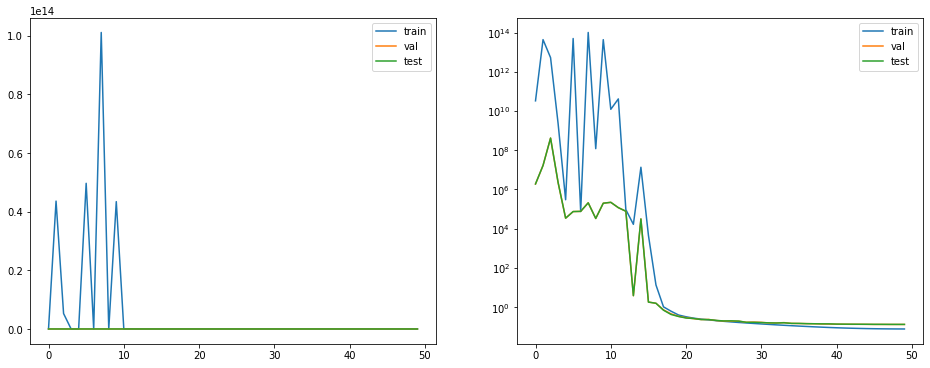

[2022-08-01 13:22:55] Loading /lfs/turing3/0/tailin/pde_data/deepsnap/mppde1d-E2-50_test_in_25_out_200.p
[2022-08-01 13:22:57] Loaded pre-saved deepsnap file at /lfs/turing3/0/tailin/pde_data/deepsnap/mppde1d-E2-50_test_in_25_out_200.p.
hash ldDNKnog_turing2, full time: 0.016345 +- 0.002601  evo time: 0.006665 +- 0.000956. #params: 4043648  #params_evo: 1314816.
hash JLf4tEYC_turing2, full time: 0.015012 +- 0.000774  evo time: 0.006102 +- 0.000308. #params: 2271360  #params_evo: 329728.
hash Un6ae7ja_turing2, full time: 0.014890 +- 0.001059  evo time: 0.005981 +- 0.000442. #params: 1630976  #params_evo: 82944.
hash 5TFpW2r7, full time: 0.014385 +- 0.000990  evo time: 0.005743 +- 0.000317. #params: 1372224  #params_evo: 20992.
hash xuaWUuBJ, full time: 0.014518 +- 0.000766  evo time: 0.005818 +- 0.000419. #params: 1258208  #params_evo: 5376.
hash WO0JMG5U, full time: 0.014135 +- 0.000856  evo time: 0.005783 +- 0.000376. #params: 1205040  #params_evo: 1408.
hash 9dhW7XBI_turing2, full ti

In [7]:
# Ablation latent size @ turing3:
all_hash = [
    "ldDNKnog_turing2", # 512
    "JLf4tEYC_turing2", # 256
    "Un6ae7ja_turing2", # 128
    "5TFpW2r7", # 64
    "xuaWUuBJ", # 32
    "WO0JMG5U", # 16
    "9dhW7XBI_turing2", # 8
    "aKXmat5Z_turing2", # 4
]
get_timing_1d(all_hash, suffix="_ablation")

[2022-08-01 13:18:02] Hash N+XmBTW+_turing3, best model at epoch 45:


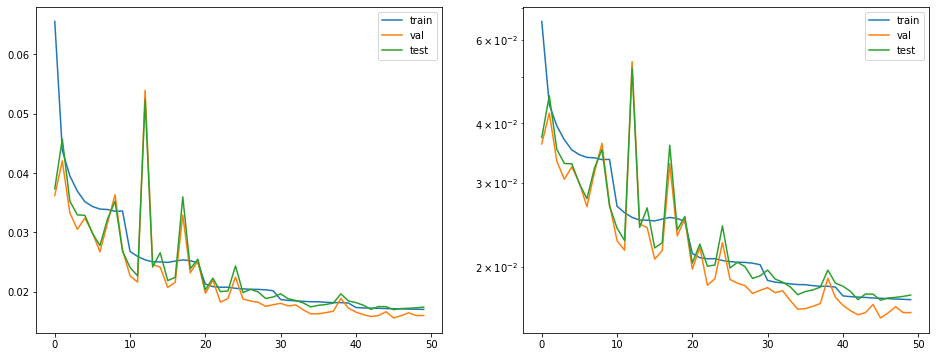

[2022-08-01 13:18:08] /lfs/turing3/0/tailin/pde_data/deepsnap/mppde1d-E2-50_test_in_25_out_200.p does not exist. Generating...
Load dataset /dfs/project/plasma/pde_data/MPNPDESolvers/CE_test_E2.h5
[2022-08-01 13:18:08] :
[2022-08-01 13:18:11] 500
[2022-08-01 13:18:15] 1000
[2022-08-01 13:18:18] 1500
[2022-08-01 13:18:21] 2000
[2022-08-01 13:18:25] 2500
[2022-08-01 13:18:28] 3000
[2022-08-01 13:18:30] 3328
[2022-08-01 13:18:31] saved generated deepsnap dataset to /lfs/turing3/0/tailin/pde_data/deepsnap/mppde1d-E2-50_test_in_25_out_200.p
hash N+XmBTW+_turing3, full time: 0.021246 +- 0.006874. #params: 292249
hash OlaHQmVh_turing3, full time: 0.021728 +- 0.004326. #params: 1138201
hash 95ODTwFm_turing3, full time: 0.022134 +- 0.007356. #params: 78169
hash k6pUtyDT_turing3, full time: 0.020981 +- 0.005741. #params: 23353
hash tMtuBQbF_turing3, full time: 0.017933 +- 0.001245. #params: 9001
hash 6AEMxxdG_turing3, full time: 0.019339 +- 0.000860. #params: 357785
hash 94vcmAJH_turing3, full t

In [6]:
# FNO @ turing3:
all_hash = [
    "N+XmBTW+_turing3",
    "OlaHQmVh_turing3",
    "95ODTwFm_turing3",
    "k6pUtyDT_turing3",
    "tMtuBQbF_turing3",
    "6AEMxxdG_turing3",
    "94vcmAJH_turing3",
    "ajb+NVzF_turing3",
    "0di76Adz_turing3",
    "F0ge5kGj_turing3",
    "Jr2biWNP_turing3",
    "kxU74861_turing3",
]
get_timing_1d(all_hash, suffix="_fno")